In [2]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.features import geometry_mask
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [3]:
PATH_SOFT_SCORE = r"/Users/hester/Desktop/data/final_weighted_score.tif"  
PATH_HARD_RAW   = r"/Users/hester/Desktop/data/final_suitability.tif"    
WORLD_SHP       = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

OUT_HARD_BIN    = r"/Users/hester/Desktop/data/hard_constraints_binary_27700.tif"
OUT_FINAL_SCORE = r"/Users/hester/Desktop/data/final_suitability_score.tif"
OUT_FINAL_CLASS = r"/Users/hester/Desktop/data/final_suitability_class.tif"

In [4]:
with rasterio.open(PATH_SOFT_SCORE) as srcS:
    S = srcS.read(1).astype("float32")
    S_meta = srcS.meta.copy()
    S_crs = srcS.crs
    S_transform = srcS.transform
    Ht, Wd = srcS.height, srcS.width
    S_nodata = srcS.nodata
    bounds = srcS.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top

S2 = S.copy()
if S_nodata is not None:
    S2[S2 == S_nodata] = np.nan
S2[(S2 < 0) | (S2 > 1)] = np.nan

In [5]:
world = gpd.read_file(WORLD_SHP)
uk = world[world["NAME"].isin(["United Kingdom"])].to_crs(S_crs)

land_mask = ~geometry_mask(
    geometries=[geom for geom in uk.geometry if geom is not None],
    out_shape=(Ht, Wd),
    transform=S_transform,
    invert=False,   
    all_touched=False
)

In [6]:
with rasterio.open(PATH_HARD_RAW) as srcH:
    H_raw = srcH.read(1).astype("float32")
    H_nodata = srcH.nodata
    if H_nodata is not None:
        H_raw[H_raw == H_nodata] = np.nan

    H01_src = np.where(np.isfinite(H_raw) & (H_raw > 0), 1.0, 0.0).astype("float32")

    H01 = np.zeros((Ht, Wd), dtype="float32")
    reproject(
        source=H01_src,
        destination=H01,
        src_transform=srcH.transform,
        src_crs=srcH.crs,
        dst_transform=S_transform,
        dst_crs=S_crs,
        resampling=Resampling.nearest,
        src_nodata=0,
        dst_nodata=0
    )

H_bin = (H01 >= 0.5).astype("uint8")

H_bin[~land_mask] = 0

metaH = S_meta.copy()
metaH.update(dtype="uint8", nodata=0, count=1, compress="lzw")
with rasterio.open(OUT_HARD_BIN, "w", **metaH) as dst:
    dst.write(H_bin, 1)

print("Saved hard binary:", OUT_HARD_BIN, " suitable ratio(on land)=", float(H_bin[land_mask].mean()))

Saved hard binary: /Users/hester/Desktop/data/hard_constraints_binary_27700.tif  suitable ratio(on land)= 0.32259544317290645


In [7]:
Final = S2 * H_bin.astype("float32")
Final[~land_mask] = np.nan

out_nodata = -9999.0
Final_out = np.where(np.isnan(Final), out_nodata, Final).astype("float32")

metaF = S_meta.copy()
metaF.update(dtype="float32", nodata=out_nodata, count=1, compress="lzw")
with rasterio.open(OUT_FINAL_SCORE, "w", **metaF) as dst:
    dst.write(Final_out, 1)

print("Saved final score:", OUT_FINAL_SCORE)

Saved final score: /Users/hester/Desktop/data/final_suitability_score.tif


In [8]:
Final_class = np.full((Ht, Wd), 255, dtype="uint8")
valid_soft = np.isfinite(S2)

Final_class[land_mask] = 0

allowed = land_mask & (H_bin == 1) & valid_soft
bins = [0.0, 0.25, 0.50, 0.75, 1.0000001]
Final_class[allowed] = np.digitize(Final[allowed], bins=bins, right=False).astype("uint8")

metaC = S_meta.copy()
metaC.update(dtype="uint8", nodata=255, count=1, compress="lzw")
with rasterio.open(OUT_FINAL_CLASS, "w", **metaC) as dst:
    dst.write(Final_class, 1)

counts = {k: int((Final_class == k).sum()) for k in [0,1,2,3,4,255]}
print("Saved final class:", OUT_FINAL_CLASS)
print("Class counts:", counts)

Saved final class: /Users/hester/Desktop/data/final_suitability_class.tif
Class counts: {0: 3467303, 1: 87949, 2: 1159861, 3: 377649, 4: 25624, 255: 50042830}


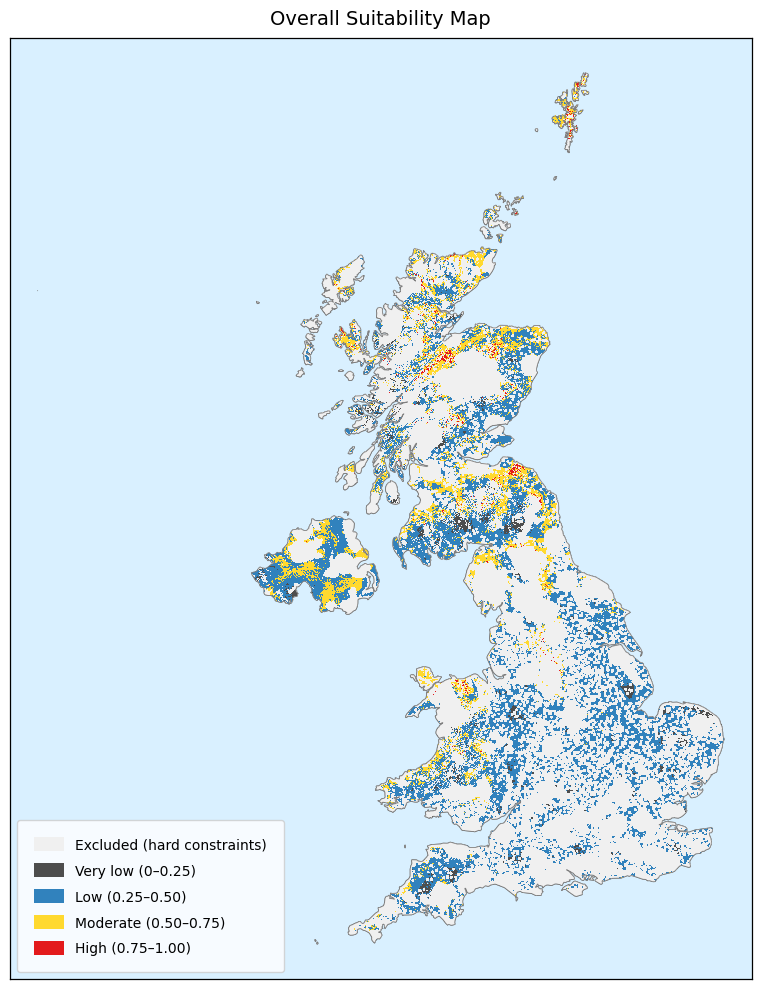

In [9]:
A = Final_class.astype("float32").copy()
A[A == 255] = np.nan 


cmap = ListedColormap([
    "#f0f0f0",  # 0 Excluded
    "#4d4d4d",  # 1 Very low
    "#3182bd",  # 2 Low
    "#ffd92f",  # 3 Moderate
    "#e31a1c",  # 4 High
])
norm = BoundaryNorm([-0.5,0.5,1.5,2.5,3.5,4.5], cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.set_facecolor("#d9f0ff")

uk.plot(
    ax=ax,
    facecolor="white",
    edgecolor="#7f7f7f",
    linewidth=0.6,
    zorder=1
)

ax.imshow(
    A,
    cmap=cmap,
    norm=norm,
    extent=(left, right, bottom, top),
    origin="upper",
    interpolation="nearest",
    zorder=2)

uk.boundary.plot(
    ax=ax,
    edgecolor="#7f7f7f",
    linewidth=0.6,
    zorder=3)

ax.set_title(
    "Overall Suitability Map",
    fontsize=14,
    pad=10)

# Legend
legend_elements = [
    Patch(facecolor="#f0f0f0", edgecolor="none", label="Excluded (hard constraints)"),
    Patch(facecolor="#4d4d4d", edgecolor="none", label="Very low (0–0.25)"),
    Patch(facecolor="#3182bd", edgecolor="none", label="Low (0.25–0.50)"),
    Patch(facecolor="#ffd92f", edgecolor="none", label="Moderate (0.50–0.75)"),
    Patch(facecolor="#e31a1c", edgecolor="none", label="High (0.75–1.00)")]


leg = ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=10,
    frameon=True,
    borderpad=1.2,
    labelspacing=0.8,
    handlelength=2.2,
    handleheight=1.2)

minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_aspect("equal", adjustable="box")

ax.set_xticks([])
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("Overall Suitability Map.png",dpi=300,bbox_inches="tight")